In [5]:
### ICON deep on

In [6]:
#%pip install xarray
!python -c "import sys; print(sys.version)"

3.12.1 (main, Jan  1 1980, 12:01:00) [GCC 13.2.0]


In [7]:
from pyproj import Proj, Transformer, transform, CRS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import xesmf as xe
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import glob
import os
import pandas as pd
import time
from itertools import groupby
from scipy.stats import linregress
from scipy import ndimage
from contrack import contrack
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import shapely
import shapely.ops as sops
import shapely.vectorized as sv

In [8]:
# My functions live in climate_indices.py in the same folder:
from utils.hw_climate_indices import (
    count_frost_days, count_summer_days, count_icing_days,
    compute_dtr, compute_CDD, compute_CWD, compute_precip_exceedance
)

# 12.5km resolution

In [25]:
###Unstructured grid
#xr_in=xr.open_mfdataset('/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed_R02B08_shallow_only/out_3/t_2m_2024*.nc')
### remaped
xr_in=xr.open_mfdataset('/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed_R02B08_shallow_only/out_7/remap_t_2m_2020*.nc',{"time": 366, "lat": -1, "lon": -1})

In [26]:
### grid spacing 
#xr_in['lon'][101] -xr_in['lon'][100]
xr_in

<xarray.Dataset> Size: 24GB
Dimensions:  (time: 1440, height: 1, lat: 1440, lon: 2880)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-02-01T01:00:00 ... 2020-04-01
  * lon      (lon) float64 23kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 12kB -89.95 -89.83 -89.7 -89.58 ... 89.67 89.8 89.92
  * height   (height) float64 8B 2.0
Data variables:
    t_2m     (time, height, lat, lon) float32 24GB dask.array<chunksize=(23, 1, 1440, 2880), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6
    source:                    version: 2024.10; revision: spack-ci_v0.1-1086...
    institution:               Max Planck Institute for Meteorology/Deutscher...
    title:                     ICON simulation
    history:                   Mon Feb 02 20:58:44 2026: cdo -P 36 remap,/cap...
    references:                see MPIM/DWD publications
    comment:                   Christian Zeman, ETHZ (zemanc) on nid005135 (L...
    CDO:                       Climate Data Operators version 2.4.0 (https://...
    cdo_openmp_thread_number:  36

In [9]:
#### Unstructured grid
#gt2m=xr_in['t_2m'].isel(height_2=0 ).resample(time='D').mean()
### remapped
#gt2m=xr_in['t_2m'].isel(height=0 ).resample(time='D').mean()

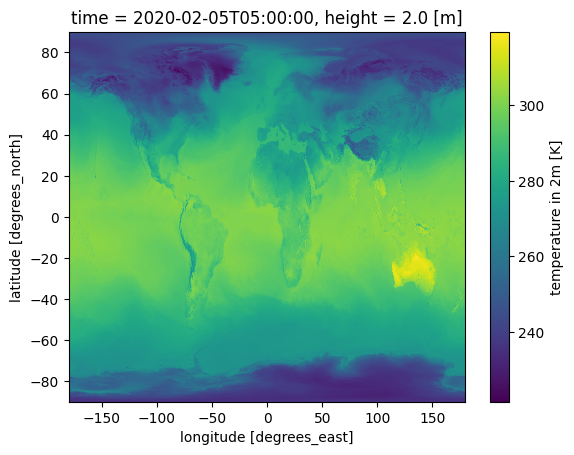

In [10]:
#one time 
xr_in['t_2m'].isel(time=100,height=0).plot()

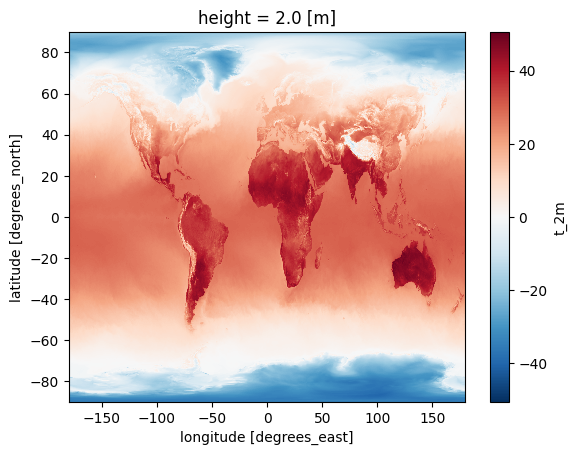

In [11]:
### max temperature
(xr_in['t_2m'].isel(height=0)-273.15).max(dim=['time']).plot()

In [12]:
### Mask to count days above the 20 (tropical nights) --> This should be minimum temperature
temp_mask = ((xr_in['t_2m'].isel(height=0)-273.15) > 20).compute() # gives true and false values (which is our mask)
#temp_mask.compute()

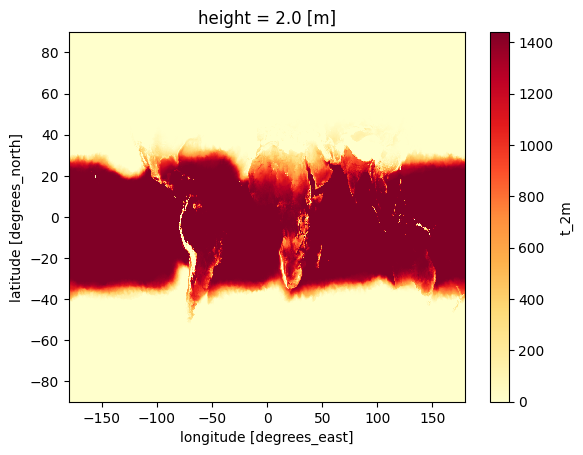

In [13]:
# Counting the days and plotting
temp_mask.sum(dim=["time"]).plot(
    cmap='YlOrRd'#, levels=np.arange(0, 200, 20)
)  # Sum up True values and plot the result

In [14]:
## Diurnal temperature range (DTR)
#1) compute max and min daily
tmin = xr_in.resample(time='1D').min().squeeze()
tmin.load()
tmin-=273 ##3 to degree 

tmax = xr_in.resample(time='1D').max().squeeze()
tmax.load()
tmax-=273 ##3 to degree 
tmax

<xarray.Dataset> Size: 1GB
Dimensions:  (lon: 2880, lat: 1440, time: 61)
Coordinates:
  * lon      (lon) float64 23kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 12kB -89.95 -89.83 -89.7 -89.58 ... 89.67 89.8 89.92
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 488B 2020-02-01 2020-02-02 ... 2020-04-01
Data variables:
    t_2m     (time, lat, lon) float32 1GB -35.35 -35.35 -35.35 ... -34.7 -34.7
Attributes:
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6
    source:                    version: 2024.10; revision: spack-ci_v0.1-1086...
    institution:               Max Planck Institute for Meteorology/Deutscher...
    title:                     ICON simulation
    history:                   Mon Feb 02 20:58:44 2026: cdo -P 36 remap,/cap...
    references:                see MPIM/DWD publications
    comment:                   Christian Zeman, ETHZ (zemanc) on nid005135 (L...
    CDO:                       Climate Data Operators version 2.4.0 (https://...
    cdo_openmp_thread_number:  36

In [15]:
#2) Compute DTR monthly
varn='fd' 
fd=compute_dtr(tmax['t_2m'], tmin['t_2m']).astype(float)

In [24]:
###Plotting

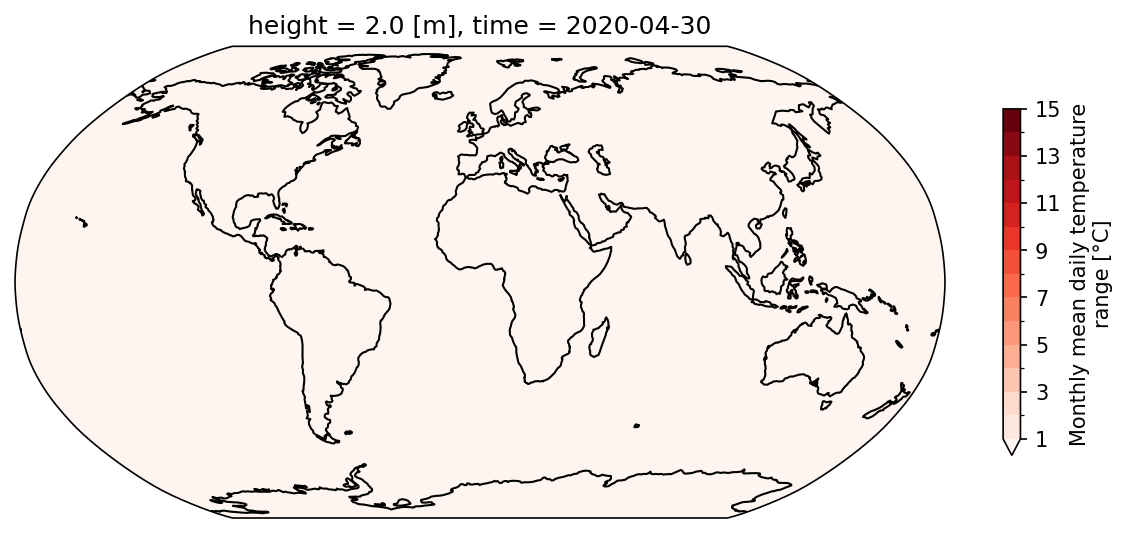

In [22]:
###one month of the year
fd_mm=fd.isel(time=2)#6)

#fd_mm.plot(cmap='Reds',levels=np.arange(1, 16, 1))
#ax.set_title(f'ICON DTR  for 2024 [time =3]');

# Create figure + axis with Robinson projection
fig, ax = plt.subplots(figsize=(10, 5),dpi=150,subplot_kw={'projection': ccrs.Robinson()})

# Plot your data on that axis
fd_mm.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # projection of your data (usually lat/lon)
    cmap='Reds',
    levels=np.arange(1, 16, 1),
    cbar_kwargs={'shrink': 0.6}
)

# Add coastlines
ax.coastlines()


# Remapped to 50 km and daily

In [14]:
#ERA5
era5_nh=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_mon.nc')['t2m'].squeeze()
era5_sh=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/SH/t2m_mon.nc')['t2m'].squeeze()
icon2km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/TS/t2m_mon.nc')['t_2m'].squeeze()
icon10km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM/TS/t2m_mon.nc')['t_2m'].squeeze()
icon10km_on=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/TS/t2m_mon.nc')['t_2m'].squeeze()
icon40km=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/t_2m/t2m_mon.nc')['t_2m'].squeeze()
### select only the NH
#da=da.sel(lat=slice(0,90))
### select only the SH
#da=da.sel(lat=slice(-90,0))

/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/coding/times.py:365: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/tmp/ipykernel_244828/2913760907.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  era5_nh=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_mon.nc')['t2m'].squeeze()


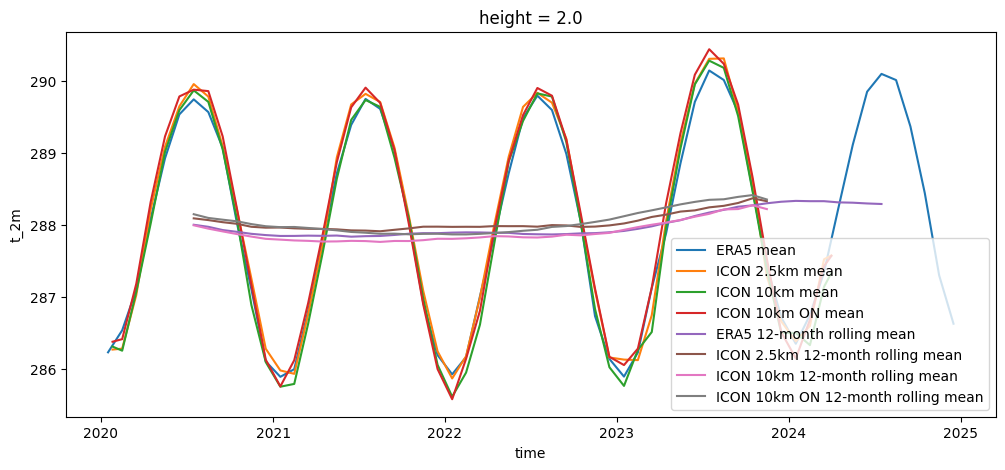

In [17]:
### time series
#area-weight mean
weights = np.cos(np.deg2rad(icon2km.lat))

era5_nh_month_mean = era5_nh.weighted(weights).mean(dim=["lat","lon"])
era5_sh_month_mean = era5_sh.weighted(weights).mean(dim=["lat","lon"])
era5_month_mean    = (era5_nh_month_mean + era5_sh_month_mean) / 2

icon_2km_month_mean     = icon2km.weighted(np.cos(np.deg2rad(icon2km.lat))).mean(dim=["lat","lon"])
icon_10km_month_mean    = icon10km.weighted(np.cos(np.deg2rad(icon10km.lat))).mean(dim=["lat","lon"])
icon_10km_on_month_mean = icon10km_on.weighted(np.cos(np.deg2rad(icon10km_on.lat))).mean(dim=["lat","lon"])
icon_40km_month_mean    = icon40km.weighted(np.cos(np.deg2rad(icon40km.lat))).mean(dim=["lat","lon"])


# >>> Key change: ensure time chunks are >= 12
era5_month_mean = era5_month_mean.chunk({'time': 120})
icon_2km_month_mean = icon_2km_month_mean.chunk({'time': 120})
icon_10km_month_mean = icon_10km_month_mean.chunk({'time': 120})
icon_10km_on_month_mean = icon_10km_on_month_mean.chunk({'time': 120})
icon_40km_month_mean = icon_40km_month_mean.chunk({'time': 120})
'''
plt.figure(figsize=(12,5))
era5_month_mean.sel(time=slice('2020','2024')).plot(label="ERA5 mean")
icon_2km_month_mean.plot(label="ICON 2.5km mean")
icon_10km_month_mean.plot(label="ICON 10km mean")
icon_10km_on_month_mean.plot(label="ICON 10km ON mean")
#icon_40km_month_mean.plot(label="ICON 40km mean")
plt.legend()

'''

# 12-month (1 year) rolling mean
era5_smooth = era5_month_mean.sel(time=slice('2020','2024')).rolling(time=12, center=True).mean() #.compute()
icon_2km_smooth = icon_2km_month_mean.rolling(time=12, center=True).mean() #.compute() #time=12, time=4
icon_10km_smooth = icon_10km_month_mean.rolling(time=12, center=True).mean() #.compute()
icon_10km_on_smooth = icon_10km_on_month_mean.rolling(time=12, center=True).mean() #.compute()
#icon_40km_smooth = icon_40km_month_mean.rolling(time=12, center=True).mean() #.compute()

# Plot smoothed
plt.figure(figsize=(12,5))

era5_month_mean.sel(time=slice('2020','2024')).plot(label="ERA5 mean")
icon_2km_month_mean.plot(label="ICON 2.5km mean")
icon_10km_month_mean.plot(label="ICON 10km mean")
icon_10km_on_month_mean.plot(label="ICON 10km ON mean")
###icon_40km_month_mean.plot(label="ICON 40km mean")

era5_smooth.plot(label="ERA5 12-month rolling mean")
icon_2km_smooth.plot(label="ICON 2.5km 12-month rolling mean")
icon_10km_smooth.plot(label="ICON 10km 12-month rolling mean")
icon_10km_on_smooth.plot(label="ICON 10km ON 12-month rolling mean")
###icon_40km_smooth.plot(label="ICON 40km 12-month rolling mean")
plt.legend()


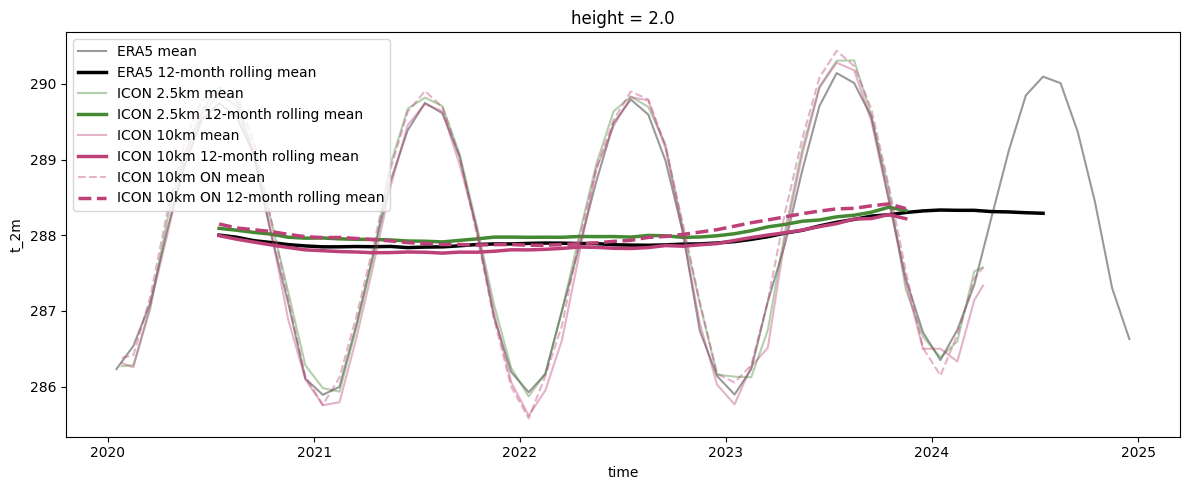

In [38]:
###figure
plt.figure(figsize=(12, 5))

# Define consistent colors for each dataset
#['darkgrey', '#6b64ff', '#6dcc4e', '#6dcc4e']
#['black', '#6b64ff', 'orange', 'orange']
#['black','#BD4078', '#F2AA3C', '#448933']
colors = {
    "era5": 'black',
    "icon_2km": '#448933', #'#BD4078',
    "icon_10km": '#BD4078', 
    "icon_10km_on":  '#BD4078',#'#448933',
    # "icon_40km": "C4",
}

# ERA5
era5_month_mean.sel(time=slice('2020', '2024')).plot(
    label="ERA5 mean", color=colors["era5"], alpha=0.4
)
era5_smooth.plot(
    label="ERA5 12-month rolling mean", color=colors["era5"], linewidth=2.5
)

# ICON 2.5 km
icon_2km_month_mean.plot(
    label="ICON 2.5km mean", color=colors["icon_2km"], alpha=0.4
)
icon_2km_smooth.plot(
    label="ICON 2.5km 12-month rolling mean", color=colors["icon_2km"], linewidth=2.5
)

# ICON 10 km
icon_10km_month_mean.plot(
    label="ICON 10km mean", color=colors["icon_10km"], alpha=0.4
)
icon_10km_smooth.plot(
    label="ICON 10km 12-month rolling mean", color=colors["icon_10km"], linewidth=2.5
)

# ICON 10 km ON
icon_10km_on_month_mean.plot(
    label="ICON 10km ON mean", color=colors["icon_10km_on"], alpha=0.4, linestyle='--'
)
icon_10km_on_smooth.plot(
    label="ICON 10km ON 12-month rolling mean", color=colors["icon_10km_on"], linewidth=2.5, linestyle='--'
)

# Optional: ICON 40 km
# icon_40km_month_mean.plot(label="ICON 40km mean", color=colors["icon_40km"], alpha=0.4)
# icon_40km_smooth.plot(label="ICON 40km 12-month rolling mean", color=colors["icon_40km"], linewidth=2.5)

plt.legend()
plt.tight_layout()


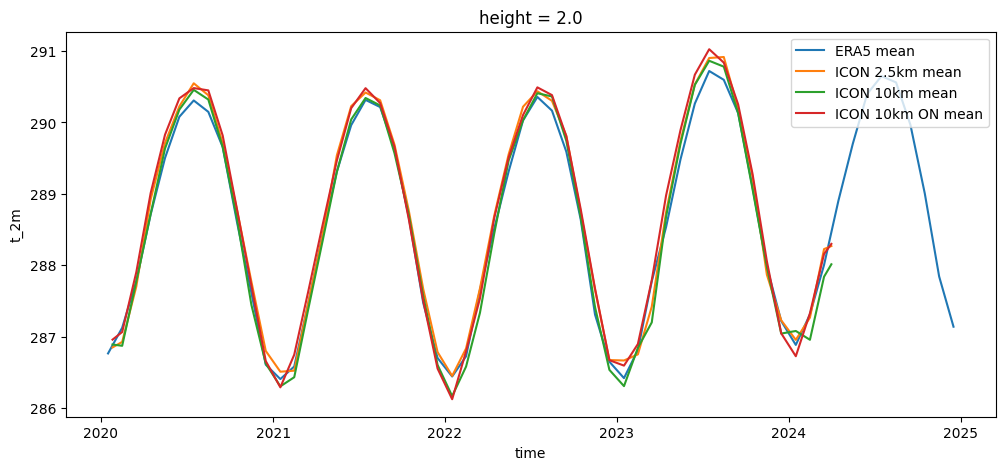

In [11]:
#Unweighted mean(dim=["lat","lon"]) overweights high latitudes. Use cosine-lat weights
LAT_CUTOFF = 80
def area_mean_no_poles(da, lat_name="lat", lon_name="lon"):
    da = da.where(abs(da[lat_name]) <= LAT_CUTOFF, drop=True)
    w = np.cos(np.deg2rad(da[lat_name]))
    return da.weighted(w).mean(dim=[lat_name, lon_name])

era5_nh_month_mean = area_mean_no_poles(era5_nh)
era5_sh_month_mean = area_mean_no_poles(era5_sh)
era5_month_mean    = (era5_nh_month_mean + era5_sh_month_mean)/2

icon_2km_month_mean     = area_mean_no_poles(icon2km)
icon_10km_month_mean    = area_mean_no_poles(icon10km)
icon_10km_on_month_mean = area_mean_no_poles(icon10km_on)
icon_40km_month_mean    = area_mean_no_poles(icon40km)

# >>> Key change: ensure time chunks are >= 12
era5_month_mean = era5_month_mean.chunk({'time': 120})
icon_2km_month_mean = icon_2km_month_mean.chunk({'time': 120})
icon_10km_month_mean = icon_10km_month_mean.chunk({'time': 120})
icon_10km_on_month_mean = icon_10km_on_month_mean.chunk({'time': 120})
icon_40km_month_mean = icon_40km_month_mean.chunk({'time': 120})

plt.figure(figsize=(12,5))
era5_month_mean.sel(time=slice('2020','2024')).plot(label="ERA5 mean")
icon_2km_month_mean.plot(label="ICON 2.5km mean")
icon_10km_month_mean.plot(label="ICON 10km mean")
icon_10km_on_month_mean.plot(label="ICON 10km ON mean")
#icon_40km_month_mean.plot(label="ICON 40km mean")
plt.legend()

In [23]:
#Select season
season = 'DJF'

#Select period
era5_nh= era5_nh.sel(time=slice('2020','2024')) 
era5_sh= era5_sh.sel(time=slice('2020','2024')) 
icon2km= icon2km.sel(time=slice('2020','2024'))
icon10km= icon10km.sel(time=slice('2020','2024'))
icon10km_on= icon10km_on.sel(time=slice('2020','2024'))
#icon40km= icon40km.sel(time=slice('2013','2017')) 

if season =='JJA':
    months_sel = [6, 7, 8]  # JJA
if season =='DJF':
    months_sel = [1, 2, 12]  # DJF

### Select season
era5_nh = era5_nh.where(era5_nh['time'].dt.month.isin(months_sel), drop=True)
era5_sh = era5_sh.where(era5_sh['time'].dt.month.isin(months_sel), drop=True)
icon2km = icon2km.where(icon2km['time'].dt.month.isin(months_sel), drop=True)
icon10km = icon10km.where(icon10km['time'].dt.month.isin(months_sel), drop=True)
icon10km_on = icon10km_on.where(icon10km_on['time'].dt.month.isin(months_sel), drop=True)
#icon40km = icon40km.where(icon40km['time'].dt.month.isin(months_sel), drop=True)

##compute mean
era5_nh_mean=era5_nh.mean(dim='time')
era5_sh_mean=era5_sh.mean(dim='time')
icon2km_mean=icon2km.mean(dim='time')
icon10km_mean=icon10km.mean(dim='time')
icon10km_on_mean=icon10km_on.mean(dim='time')
#icon40km_mean=icon40km.mean(dim='time')

### merge ERA5 data
era5_nh_mean = era5_nh_mean.sortby('lat')
era5_sh_mean = era5_sh_mean.sortby('lat')
era5_nh_mean = era5_nh_mean.sel(lat=era5_nh_mean.lat > 0)
era5_merged = xr.concat([era5_sh_mean, era5_nh_mean], dim='lat')

In [24]:
### Dealing with different strucuture in ICON files (OLD vs new ICON simulations)
'''
# Rename if needed (only if your dims are not exactly 'lat'/'lon')
# icon2km_mean = icon2km_mean.rename({'latitude':'lat','longitude':'lon'})
# icon10km_mean = icon10km_mean.rename({'latitude':'lat','longitude':'lon'})

icon40_ll = icon40km_mean.assign_coords(
    lon=(((icon40km_mean.lon + 180) % 360) - 180)
).sortby('lon')
icon40_ll
#Regrid/interpolate icon10 onto the icon2 latitude grid
icon40_on_icon10 = icon40_ll.interp(
    lat=icon10km_on_mean.lat,
    lon=icon10km_on_mean.lon,
    method="linear"
)

diff =icon10km_mean - icon40_on_icon10  #We could use icon10km_on_mean - icon40km_mean when finish
'''

'\n# Rename if needed (only if your dims are not exactly \'lat\'/\'lon\')\n# icon2km_mean = icon2km_mean.rename({\'latitude\':\'lat\',\'longitude\':\'lon\'})\n# icon10km_mean = icon10km_mean.rename({\'latitude\':\'lat\',\'longitude\':\'lon\'})\n\nicon40_ll = icon40km_mean.assign_coords(\n    lon=(((icon40km_mean.lon + 180) % 360) - 180)\n).sortby(\'lon\')\nicon40_ll\n#Regrid/interpolate icon10 onto the icon2 latitude grid\nicon40_on_icon10 = icon40_ll.interp(\n    lat=icon10km_on_mean.lat,\n    lon=icon10km_on_mean.lon,\n    method="linear"\n)\n\ndiff =icon10km_mean - icon40_on_icon10  #We could use icon10km_on_mean - icon40km_mean when finish\n'

In [25]:
#ERA5 mean
# --- Build panel fields ---
da_era5 = era5_merged- 273.15
da_icon2 = icon2km_mean- 273.15
da_bias_2km = (icon2km_mean - era5_merged)
da_bias_10km = (icon10km_mean - era5_merged)
da_bias_10km_on = (icon10km_on_mean - era5_merged)
#da_bias_40km = (icon40_on_icon10 - era5_merged)

da_deltares = (icon2km_mean - icon10km_mean) #We could use icon10km_on_mean - icon40km_mean when finish

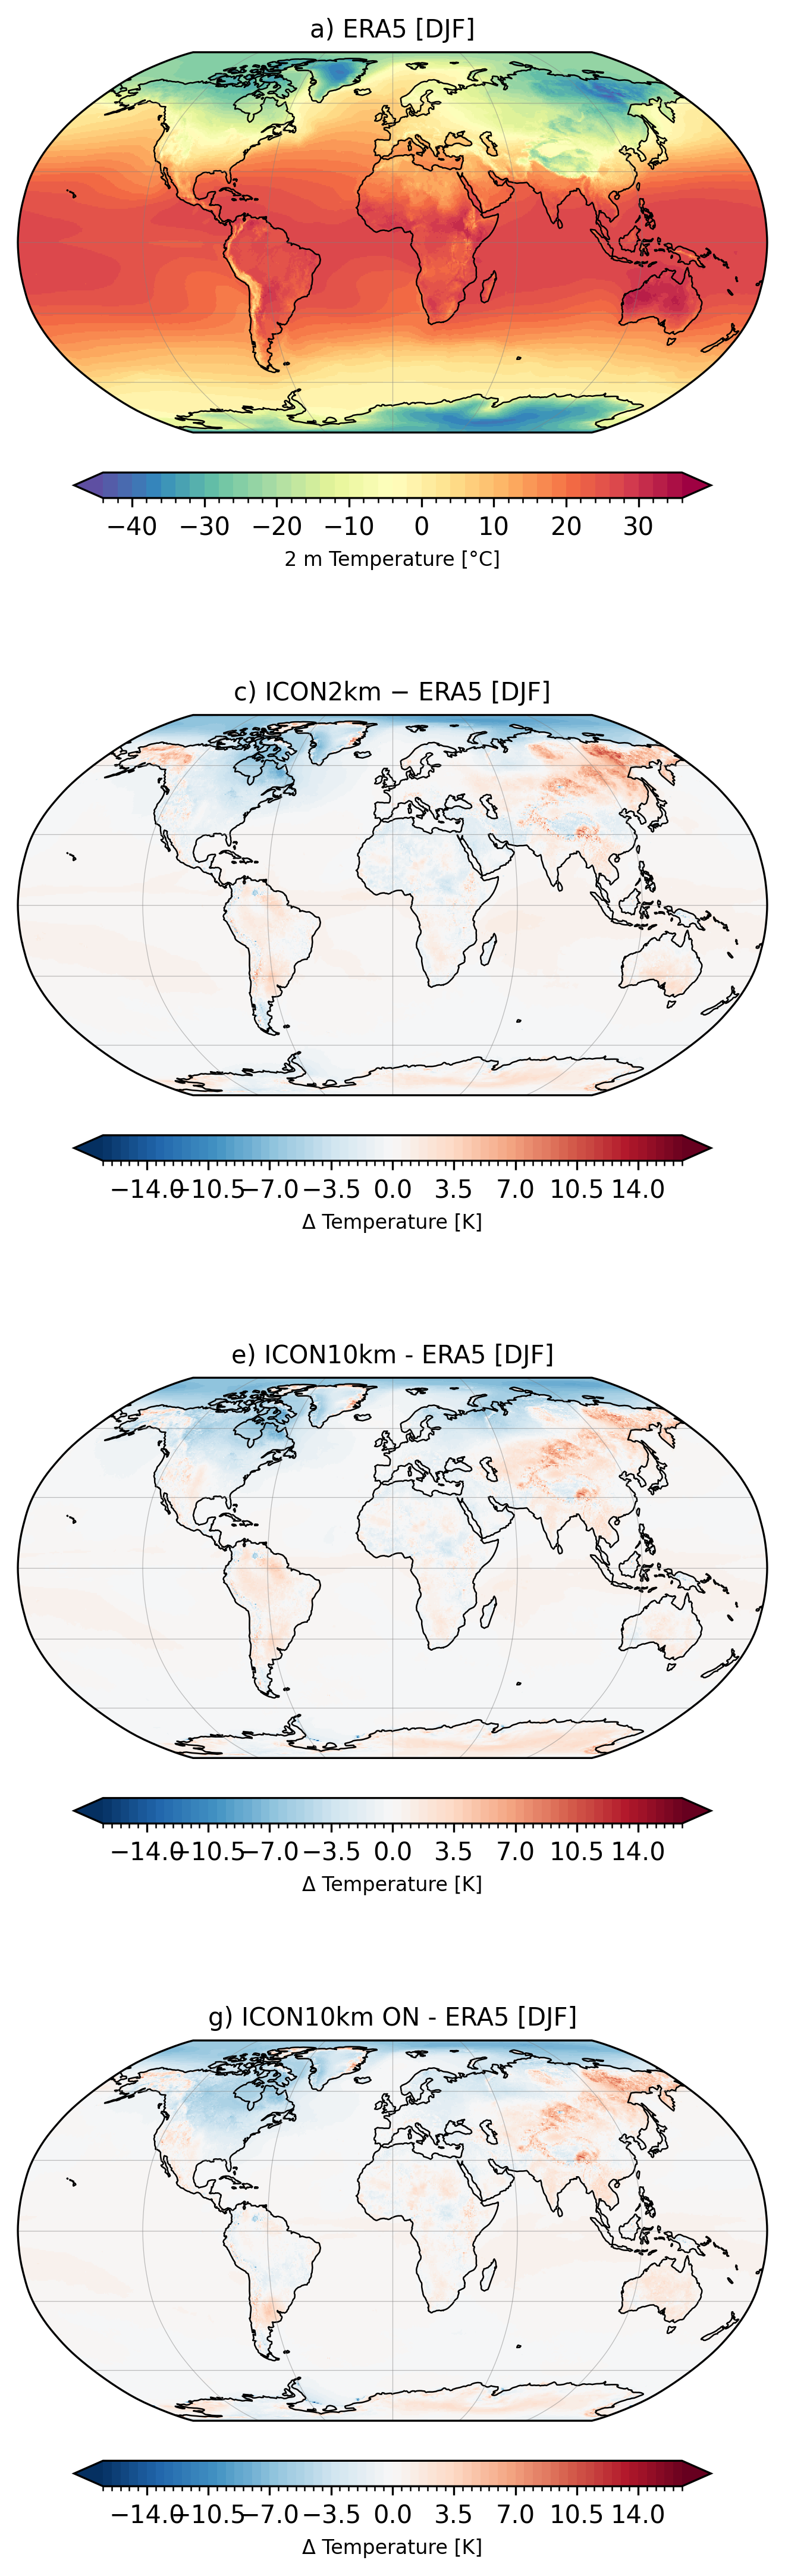

In [26]:
### PLOTTING 
data_list = [da_era5, da_bias_2km , da_bias_10km, da_bias_10km_on]

if season =='DJF':
#    titles = ["a) ERA5", "c) ICON2km − ERA5", "e) ICON2km − ICON10km"]
    titles = ["a) ERA5", "c) ICON2km − ERA5", "e) ICON10km - ERA5", "g) ICON10km ON - ERA5"]
if season =='JJA':
#    titles = ["b) ERA5", "d) ICON2km − ERA5", "f) ICON2km − ICON10km"]
    titles = ["b) ERA5", "d) ICON2km − ERA5", "f) ICON10km - ERA5", "h) ICON10km ON - ERA5"]
    
# --- Projection / transform ---
# --- Projection ---
proj = ccrs.Robinson(central_longitude=0)
pc = ccrs.PlateCarree()

# --- Levels ---
tmin = float(np.nanmin([da_era5.min(), da_icon2.min()]))
tmax = float(np.nanmax([da_era5.max(), da_icon2.max()]))

tmin = np.floor(tmin / 2) * 2
tmax = np.ceil(tmax / 2) * 2
temp_levels = np.arange(tmin, tmax + 0.1, 2)

dmax = float(np.nanmax(np.abs([da_bias_2km.min(), da_bias_2km.max(),
                               da_deltares.min(), da_deltares.max()])))
dmax = np.ceil(dmax * 2) / 2
delta_levels = np.arange(-dmax, dmax + 0.01, 0.5)

temp_cmap = "Spectral_r"
delta_cmap = "RdBu_r"

# --- Figure ---
fig, axes = plt.subplots(
    4, 1, figsize=(4.5, 15), dpi=300,
    subplot_kw={"projection": proj}
)

for ax, da, title in zip(axes, data_list, titles):
    ax.set_global()
    ax.coastlines(linewidth=0.6)
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "physical", "land", "50m",
            edgecolor="face", facecolor="lightgrey", alpha=0.6
        ),
        zorder=0
    )
    gl = ax.gridlines(crs=pc, linewidth=0.3, color="gray", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    # --- Plot selection ---
    if title.startswith("a)") or title.startswith("b)"):
        im = da.plot(
            ax=ax,
            transform=pc,
            cmap=temp_cmap,
            levels=temp_levels,
            extend="both",
            add_colorbar=False
        )
        cbar = fig.colorbar(
            im, ax=ax, orientation="horizontal",
            pad=0.07, aspect=25, shrink=0.85
        )
        cbar.set_label("2 m Temperature [°C]", fontsize=8)

    else:
        im = da.plot(
            ax=ax,
            transform=pc,
            cmap=delta_cmap,
            levels=delta_levels,
            extend="both",
            add_colorbar=False
        )
        cbar = fig.colorbar(
            im, ax=ax, orientation="horizontal",
            pad=0.07, aspect=25, shrink=0.85
        )
        cbar.set_label("Δ Temperature [K]", fontsize=8)

    ax.set_title(title + " [" + season+ "]", fontsize=10)

# Hide unused axes
for ax in axes.flatten()[len(data_list):]:
    ax.set_visible(False)
    
# Extra spacing so colorbars never collide
plt.subplots_adjust(bottom=0.18, wspace=0.05)

plt.tight_layout()

# If you want to save:
fig.savefig("t2m_1x4_robinson_"+season+".png", dpi=300, bbox_inches="tight", facecolor="white")

In [27]:
### Make functions to do it faster

In [28]:
def season_months(season: str):
    season = season.upper()
    if season == "JJA":
        return [6, 7, 8]
    if season == "DJF":
        return [12, 1, 2]
    raise ValueError("season must be 'DJF' or 'JJA'")

def merge_era5_nh_sh(era5_nh_mean, era5_sh_mean):
    # Ensure ascending lat; drop 0 from NH to avoid duplication at equator
    era5_nh_mean = era5_nh_mean.sortby("lat").sel(lat=era5_nh_mean.lat > 0)
    era5_sh_mean = era5_sh_mean.sortby("lat")
    return xr.concat([era5_sh_mean, era5_nh_mean], dim="lat")

def lon_0_360_to_minus180_180(da):
    return da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby("lon")

def prepare_season_fields(
    era5_nh, era5_sh, icon2km, icon10km, icon10km_on,
    season: str,
    era5_period=("2020", "2024"),
    icon2_period=("2020", "2024"),
    icon10_period=("2020", "2024"),
    icon10_on_period=("2020", "2024"),
#    icon40_period=("2013", "2017"),
):
    months_sel = season_months(season)

    # Select time windows
    era5_nh_sel = era5_nh.sel(time=slice(*era5_period))
    era5_sh_sel = era5_sh.sel(time=slice(*era5_period))
    icon2_sel   = icon2km.sel(time=slice(*icon2_period))
    icon10_sel  = icon10km.sel(time=slice(*icon10_period))
    icon10_on_sel  = icon10km_on.sel(time=slice(*icon10_on_period))

    # Select season months
    era5_nh_sel = era5_nh_sel.where(era5_nh_sel["time"].dt.month.isin(months_sel), drop=True)
    era5_sh_sel = era5_sh_sel.where(era5_sh_sel["time"].dt.month.isin(months_sel), drop=True)
    icon2_sel   = icon2_sel.where(icon2_sel["time"].dt.month.isin(months_sel), drop=True)
    icon10_sel  = icon10_sel.where(icon10_sel["time"].dt.month.isin(months_sel), drop=True)
    icon10_on_sel  = icon10_on_sel.where(icon10_on_sel["time"].dt.month.isin(months_sel), drop=True) ## to fix

    
    # Seasonal means
    era5_nh_mean = era5_nh_sel.mean("time")
    era5_sh_mean = era5_sh_sel.mean("time")
    icon2_mean   = icon2_sel.mean("time")
    icon10_mean  = icon10_sel.mean("time")
    icon10_on_mean  = icon10_on_sel.mean("time")

    # Merge ERA5 hemispheres to global
    era5_merged = merge_era5_nh_sh(era5_nh_mean, era5_sh_mean)

    # Regrid ICON10 -> ICON2 grid
#    icon40_ll = lon_0_360_to_minus180_180(icon40_mean)
#    icon40_on_icon2 = icon40_ll.interp(lat=icon2_mean.lat, lon=icon2_mean.lon, method="linear")

    # Build fields for panels
    da_era5     = era5_merged - 273.15
    da_icon2    = icon2_mean - 273.15
    da_bias     = icon2_mean - era5_merged          # delta in K == delta in °C
    da_deltares = icon2_mean - icon10_mean      # delta in K == delta in °C
    da_deep = icon10_mean - icon10_on_mean      # delta in K == delta in °C

    return {
        "season": season.upper(),
        "era5": da_era5,
        "bias": da_bias,
        "deltares": da_deltares,
        "deep": da_deep,
    }

In [32]:
####plotiting helpers
def compute_common_levels(season_dicts, temp_step=2, delta_step=0.5):
    # Temperature from ERA5 + ICON2 across both seasons
    tmin = float(np.nanmin([d["era5"].min() for d in season_dicts] + [d["era5"].min() for d in season_dicts]))
    tmax = float(np.nanmax([d["era5"].max() for d in season_dicts] + [d["era5"].max() for d in season_dicts]))
    tmin = np.floor(tmin / temp_step) * temp_step
    tmax = np.ceil(tmax / temp_step) * temp_step
    temp_levels = np.arange(tmin, tmax + 0.1, temp_step)

    # Deltas from bias + deltares across both seasons (symmetric)
    dmax = float(np.nanmax([
        np.abs(d["bias"]).max() for d in season_dicts
    ] + [
        np.abs(d["deltares"]).max() for d in season_dicts
    ]))
    dmax = np.ceil(dmax / delta_step) * delta_step
#    delta_levels = np.arange(-dmax, dmax + 0.001, delta_step)
    delta_levels =  np.arange(-10, 10 + 0.001, 1)

    return temp_levels, delta_levels

def plot_2x4_robinson(season_top, season_bottom, savepath=None):
    # season_top/bottom are dicts returned by prepare_season_fields()

    proj = ccrs.Robinson(central_longitude=0)
    pc = ccrs.PlateCarree()

    # Common levels across seasons (recommended for comparability)
    temp_levels, delta_levels = compute_common_levels([season_top, season_bottom], temp_step=2, delta_step=0.5)

    temp_cmap = "Spectral_r"
    delta_cmap = "RdBu_r"

    # Panel order per row
    # 1) ERA5, 2) ICON2-ERA5, 3) ICON2-ICON10, 4) ICON2
    panel_keys = ["era5", "bias", "deltares", "deep"]
#    panel_keys = ["era5", "bias", "deltares"]

    # Titles per row
    titles_row = ["ERA5", "ICON2km − ERA5", "ICON2km − ICON10km", "ICON10km -ICON10km ON"]

    fig, axes = plt.subplots(
        2, 4, figsize=(16, 7.8), dpi=300,
        subplot_kw={"projection": proj}
    )

    for r, season_dict in enumerate([season_top, season_bottom]):
        season_label = season_dict["season"]
        for c, (key, base_title) in enumerate(zip(panel_keys, titles_row)):
            ax = axes[r, c]
            da = season_dict[key]

            ax.set_global()
            ax.coastlines(linewidth=0.6)
            ax.add_feature(
                cfeature.NaturalEarthFeature(
                    "physical", "land", "50m",
                    edgecolor="face", facecolor="lightgrey", alpha=0.6
                ),
                zorder=0
            )
            gl = ax.gridlines(crs=pc, linewidth=0.3, color="gray", alpha=0.5)
            gl.top_labels = False
            gl.right_labels = False
            # Reduce label clutter in multi-panel
            gl.left_labels = (c == 0)
            gl.bottom_labels = (r == 1)

            # Plot and per-axis colorbar
            if key in ["era5", "icon2"]:
                im = da.plot(
                    ax=ax, transform=pc,
                    cmap=temp_cmap, levels=temp_levels, extend="both",
                    add_colorbar=False
                )
                cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.06,
                                    aspect=25, shrink=0.85)
                cbar.set_label("2 m Temperature [°C]", fontsize=8)
            else:
                im = da.plot(
                    ax=ax, transform=pc,
                    cmap=delta_cmap, levels=delta_levels, extend="both",
                    add_colorbar=False
                )
                cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.06,
                                    aspect=25, shrink=0.85)
                cbar.set_label("Δ Temperature [K]", fontsize=8)

            ax.set_title(f"{'abcd'[c]}) {base_title} ({season_label})", fontsize=10)

    # Layout: extra vertical space because each panel has its own cbar
    plt.subplots_adjust(hspace=0.22, wspace=0.05, bottom=0.06, top=0.95)

    if savepath is not None:
        fig.savefig(savepath, dpi=300, bbox_inches="tight", facecolor="white")

    return fig, axes

/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/coding/times.py:365: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/tmp/ipykernel_6108/3517368132.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  era5_nh=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_mon.nc')['t2m'].squeeze()


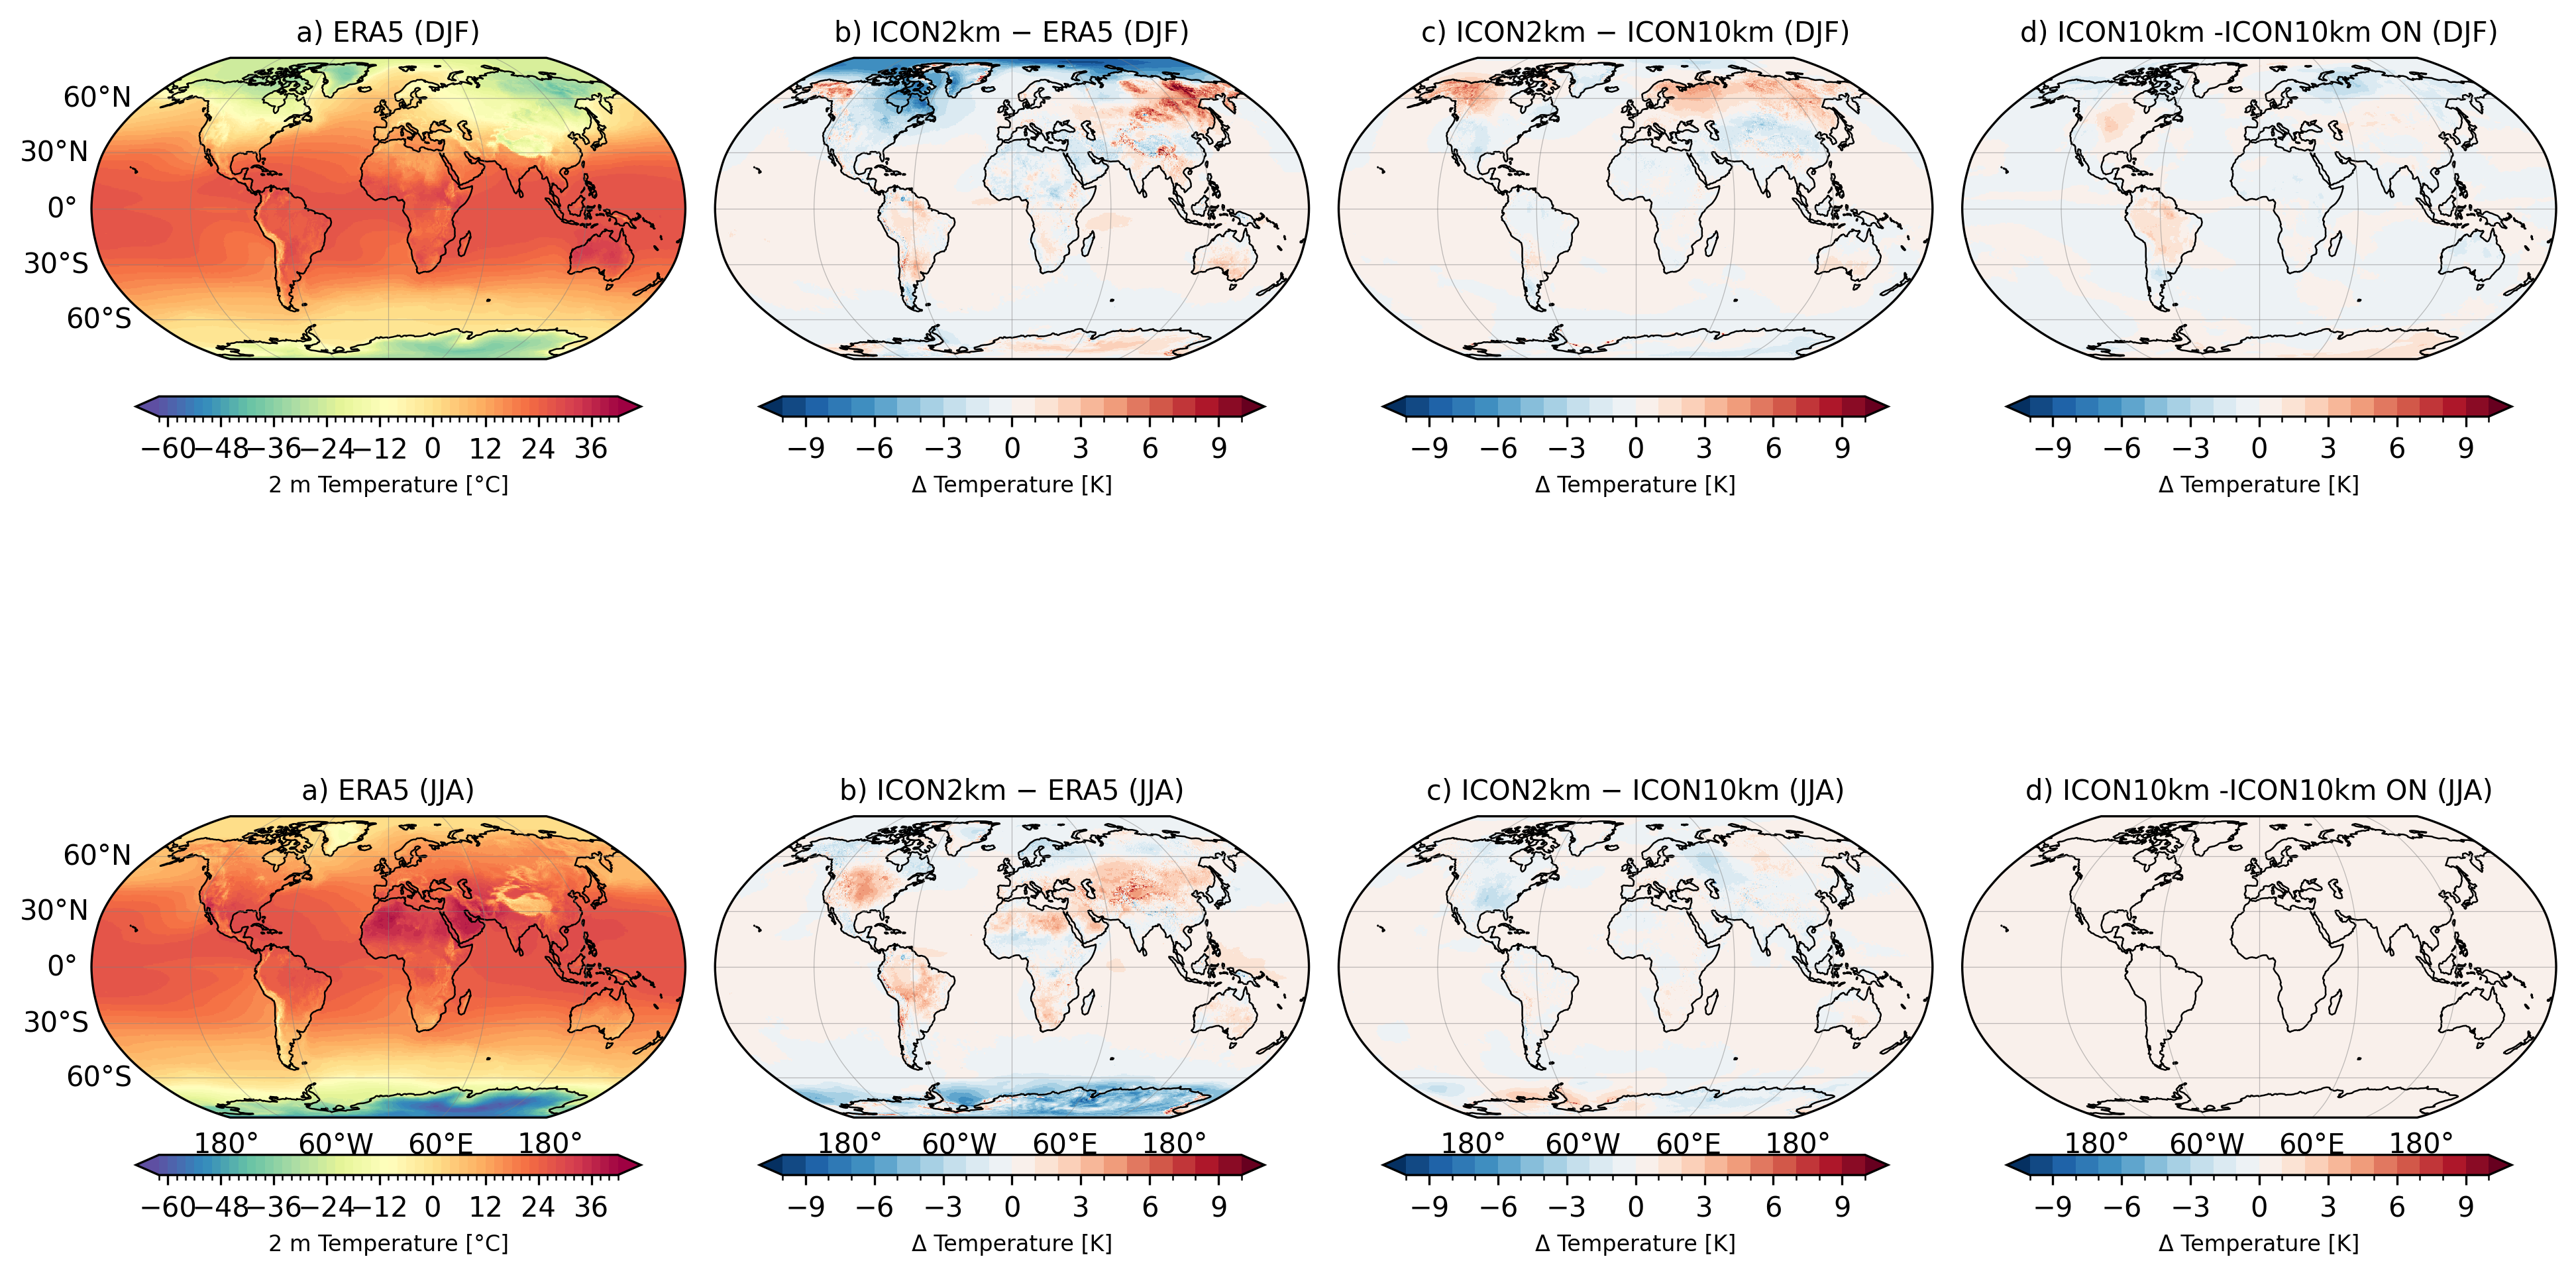

In [33]:
###open files and plot
era5_nh=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_mon.nc')['t2m'].squeeze()
era5_sh=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/SH/t2m_mon.nc')['t2m'].squeeze()
icon2km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/TS/t2m_mon.nc')['t_2m'].squeeze()
icon10km=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM/TS/t2m_mon.nc')['t_2m'].squeeze()
icon10km_on=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/TS/t2m_mon.nc')['t_2m'].squeeze()
icon40km=xr.open_dataset('/capstor/scratch/cscs/edolores/old_icon/t_2m/t2m_mon.nc')['t_2m'].squeeze()

djf = prepare_season_fields(era5_nh, era5_sh, icon2km, icon10km,  icon10km_on, season="DJF")
jja = prepare_season_fields(era5_nh, era5_sh, icon2km, icon10km, icon10km, season="JJA")
#djf
fig, axes = plot_2x4_robinson(djf, jja, savepath="t2m_2x4_DJF_JJA_robinson.png")
#plt.show()

# Traditional identifying heatwaves

In [34]:
# My functions live in HW_Russo_exclaim.py in the same folder:
from HW_Russo_exclaim import (
    drop_feb29, dayofyear_365, circular_day_distance,
    compute_tr90d, label_runs_1d, run_lengths_from_labels_1d,
    detect_heatwaves,_season_masks_from_profile, split_heatwaves_by_season,
    _events_full_len_assign_season,durations_full_event_per_season_year,
    make_land_mask_like, make_land_mask
)

In [35]:
tmax=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/TMAX/tmax_day_*',{"time": 366, "lat": 181, "lon": 720})['t_2m'].squeeze()
#tmax = tmax.chunk({"time": 366, "lat": 181, "lon": 720})  # adjust to your RAM/cluster
tmax=tmax.sel(lat=slice(0,90)) # Northern hemisphere
tmax

/tmp/ipykernel_6108/3304482951.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 181. This could degrade performance. Instead, consider rechunking after loading.
  tmax=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/TMAX/tmax_day_*',{"time": 366, "lat": 181, "lon": 720})['t_2m'].squeeze()
/tmp/ipykernel_6108/3304482951.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 181. This could degrade performance. Instead, consider rechunking after loading.
  tmax=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/TMAX/tmax_day_*',{"time": 366, "lat": 181, "lon": 720})['t_2m'].squeeze()
/tmp/ipykernel_6108/3304482951.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 181. This could degrade performance. Instead, consider rechunking after loading.
  tmax=xr.open_mfdataset('/capstor/scra

<xarray.DataArray 't_2m' (time: 1534, lat: 181, lon: 720)> Size: 800MB
dask.array<getitem, shape=(1534, 181, 720), dtype=float32, chunksize=(365, 180, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-20T11:30:00 ... 2024-04-01
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: maximum

In [36]:
# ----------------------------
# Main pipeline
# ----------------------------
# 1) Compute Tr90d on 2020–2024 (±15 days => 31-day window) (own climatology)
tr90d = compute_tr90d(tmax, ref_start="2020-01-20", ref_end="2024-04-01",
                      window_halfwidth=15, q=0.90)

## open 90th percentile created from ERA5 1961–1990 
###
#tr90d=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/Heatwaves/Russo/TR90d_1961_1990.nc')['Tr90d']
#tr90d#.isel(dayofyear=100).plot()

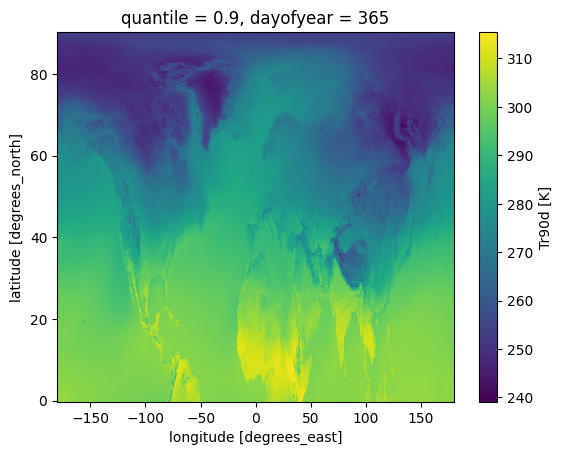

In [37]:
tr90d.isel(dayofyear=364).plot()

In [38]:
# 2) Detect heatwaves across the full record (1959–2023)
hw_mask, hot_mask, tr_full = detect_heatwaves(tmax, tr90d, min_duration=3)

In [39]:
### Saving
## NH
hw_mask.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask_simclim.nc')
hot_mask.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hot_mask_simclim.nc')
tr_full.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/tr_full_simclim.nc')
##SH
#hw_mask.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/SH/hw_mask_simclim.nc')
#hot_mask.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/SH/hot_mask_simclim.nc')
#tr_full.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/SH/tr_full_simclim.nc')

### Opening saved data
#hw_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask_simclim.nc')['heatwave_day']
#hot_mask=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hot_mask_simclim.nc')['hot_day']
#tr_full=xr.open_dataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/tr_full_simclim.nc')['Tr90d']
#hw_mask

In [40]:
# ----------------------------
# Optional: yearly diagnostics
# ----------------------------
# Use the no-leap time axis to match hw_mask
t_noleap = drop_feb29(tmax)

### error from 14.10.2025:
# before the rolling in detect_heatwaves
#t_noleap = drop_feb29(tmax).chunk({'time': -1, 'lat': 90, 'lon': 180})

# (a) number of heatwave days per year
hw_days_per_year = hw_mask.resample(time="YS").sum("time")
hw_days_per_year.name = "heatwave_days"

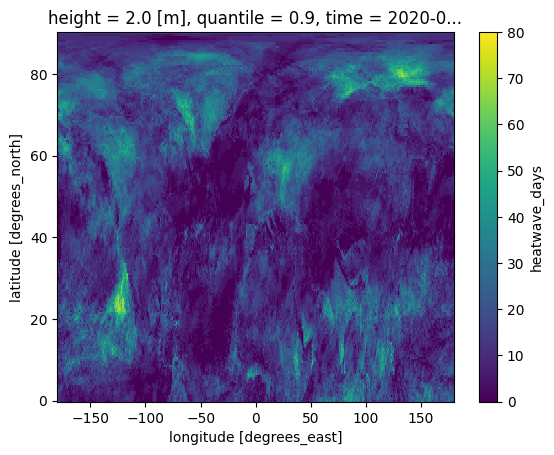

In [41]:
hw_days_per_year.isel(time=0).plot()

In [42]:
#orginal
mean_hw_days=hw_days_per_year.mean(dim='time')#.plot()#levels=np.arange(0,30,3))

### error from 14.10.2025:
# Example: mean number of heatwave days per year at each grid point
#mean_hw_days = (hw_mask.astype('i1').resample(time='YS').sum('time').mean('time'))

In [43]:
'''
### Full map
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw_days.plot(ax=ax1, cmap='YlOrRd', levels=np.arange(0,300,30),transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
'''

'\n### Full map\nproj = ccrs.Robinson(central_longitude=0, globe=None)\n\nfig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={\'projection\': proj})\nplot=mean_hw_days.plot(ax=ax1, cmap=\'YlOrRd\', levels=np.arange(0,300,30),transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})\n# Add features\nax1.add_feature(cfeature.NaturalEarthFeature(\'physical\', \'land\', \'50m\', \n                                            edgecolor=\'face\', facecolor=\'grey\', alpha=0.30), zorder=20)\n'

/tmp/ipykernel_6108/3604489795.py:25: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


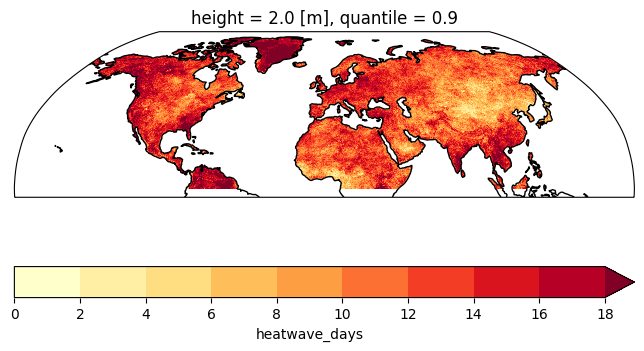

In [44]:
## masking

# --- names of coords ---
lat_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lat'))
lon_name = next(n for n in mean_hw_days.coords if n.lower().startswith('lon'))

# --- 2D lon/lat matching your DataArray's grid & dim order ---
# These come back with dims ordered consistently (use them!)
lon2d, lat2d = xr.broadcast(mean_hw_days[lon_name], mean_hw_days[lat_name])

# Wrap to [-180, 180] for polygon tests
lon_wrapped = ((lon2d + 180) % 360) - 180

# --- Read Natural Earth land polygons (path -> Reader -> geometries) ---
shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
reader = shpreader.Reader(shapefile)
geoms = list(reader.geometries())

# --- Build mask with EXACTLY the same dims/coords as lon2d/lat2d ---
mask_np = np.zeros(lon2d.shape, dtype=bool)
# Use .values so shapely gets numpy arrays
xv = lon_wrapped.values
yv = lat2d.values
for g in geoms:
    mask_np |= sv.contains(g, xv, yv)

mask_da = xr.DataArray(
    mask_np,
    coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]},
    dims=lat2d.dims,  # keep the same dim order as broadcast gave us
)

# If your field has extra dims (e.g., time), broadcast mask to match
mask_da, _ = xr.broadcast(mask_da, mean_hw_days)

# --- Apply mask & plot ---
mean_hw_days_land = mean_hw_days.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_days_land.plot(
    ax=ax1,
    cmap='YlOrRd',
#    levels=np.arange(0, 100, 10),
    levels=np.arange(0, 20, 2),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()
#ax1.set_global()

In [45]:
# full
hw_days_per_year.sel(time=slice('2020','2023')).mean(dim=['lat','lon']).values
#over land
#hw_days_land = hw_days_per_year.where(mask_da)
#hw_days_land.sel(time=slice('2020','2023')).mean(dim=['lat','lon']).values 

array([14.03144567,  8.80085942, 11.78955648, 23.32308165])

In [46]:
# (b) number of heatwave events per year (count unique runs in each year)
# Dask-safe event count per year: count 1st day of each heatwave run
event_starts = hw_mask & (~hw_mask.shift(time=1, fill_value=False))
hw_events_per_year = event_starts.resample(time="YS").sum("time").astype("int32")
hw_events_per_year.name = "heatwave_events"

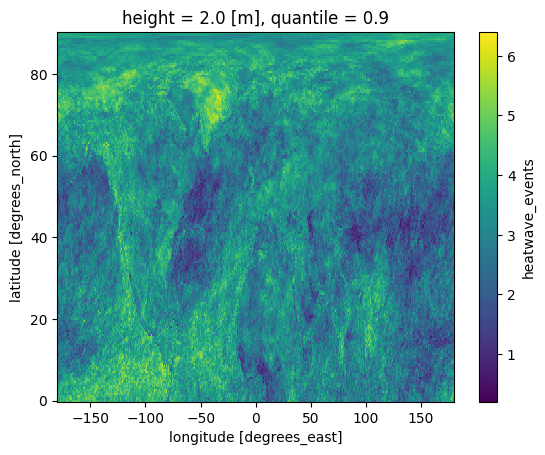

In [47]:
#hw_events_per_year.isel(time=0).plot()
hw_events_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))

In [48]:
# (c) duration per year — Dask-safe, no ndimage, no groupby on chunked labels
'''
# 0/ prep
x = hw_mask  # (time, lat, lon) boolean

# 1) find run starts
start = x & (~x.shift(time=1, fill_value=False))

# 2) numeric time index
idx = xr.DataArray(
    np.arange(x.sizes["time"], dtype=np.int64),
    coords={"time": x.time},
    dims="time",
)

# 3) forward-fill the start index across each run
start_idx = idx.where(start)                     # start index at run starts, NaN elsewhere
start_idx_ffill = start_idx.ffill("time")        # propagate start index forward within runs

# 4) run length per day (only for True days; zeros otherwise)
run_len = xr.where(x, (idx - start_idx_ffill + 1), 0).astype("int32")

# 5a) yearly mean run length
hw_mean_duration_per_year = run_len.resample(time="YS").mean("time").astype("int32")
hw_mean_duration_per_year.name = "mean_heatwave_duration"
# 5b) yearly maximum run length
#hw_max_duration_per_year = run_len.resample(time="YS").max("time").astype("int32")
#hw_max_duration_per_year.name = "max_heatwave_duration"
'''
#new routines
# Boolean mask of heatwave days (already min_duration>=3), shape (time, lat, lon)
x = hw_mask

# run starts (you already had this)
start = x & (~x.shift(time=1, fill_value=False))

# numeric time index
idx = xr.DataArray(np.arange(x.sizes["time"], dtype=np.int64),
                   coords={"time": x.time}, dims="time")

# forward-fill start index and compute per-day run length
start_idx = idx.where(start)
start_idx_ffill = start_idx.ffill("time")
run_len = xr.where(x, (idx - start_idx_ffill + 1), 0).astype("int32")

# --- NEW: pick event lengths only at run ENDS ---
end = x & (~x.shift(time=-1, fill_value=False))          # last day of each event
event_len = run_len.where(end)                            # lengths at ends; NaN elsewhere

# summarize by YEAR OF THE END DAY (change "YS" to "AS-Dec" if you prefer)
hw_mean_duration_per_year = event_len.resample(time="YS").mean("time")
hw_max_duration_per_year  = event_len.resample(time="YS").max("time")

# optional: long-term means/maps
mean_of_yearly_means = hw_mean_duration_per_year.mean("time")
max_of_yearly_max    = hw_max_duration_per_year.max("time")

In [49]:
#hw_max_duration_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))
#mean_of_yearly_means.plot()#levels=np.arange(0,10,1))

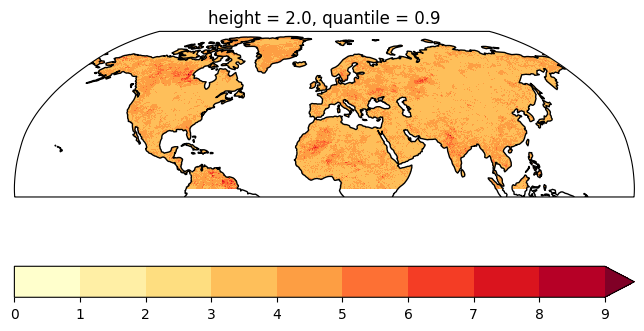

In [50]:
mean_hw_duration=hw_mean_duration_per_year.sel(time=slice('2020','2023')).mean(dim='time') 
# --- Apply mask & plot ---
mean_hw_duration_land = mean_hw_duration.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_duration_land.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 10, 1),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()

In [51]:
### distribution


In [23]:
# (d) mean intensity (tmax - Tr90d) over heatwave days per year
intensity = (drop_feb29(tmax) - tr_full).where(hw_mask)
mean_intensity_per_year = intensity.resample(time="YS").mean("time")
mean_intensity_per_year.name = "mean_intensity_above_Tr90d"

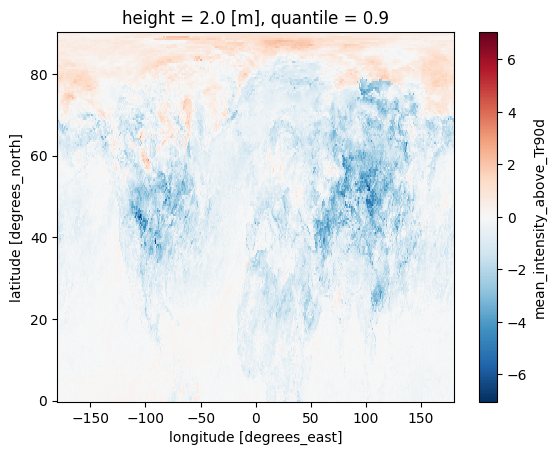

In [24]:
mean_intensity_per_year.mean(dim='time').plot()#levels=np.arange(0,30,3))

## 3) Season-split 

In [52]:
# (e) Season-split — returns a [season, time, lat, lon] boolean mask
season_hw = split_heatwaves_by_season(hw_mask.chunk(dict(time=-1)))

### average per season
summer = season_hw.sel(season="JJA")                 # includes May–Sep by design
#summer = season_hw.sel(season="DJF")                 # includes Nov–Mar by design

summer_yearly = summer.groupby("time.year").sum("time") # days per year at each gridpoint
summer_yearly_mean = summer_yearly.mean("year").compute()         # average per year
summer_yearly_mean.attrs["units"] = "days per season"

summer_yearly_mean.attrs["long_name"] = "Mean JJA heatwave days per season"
#summer_yearly_mean.attrs["long_name"] = "Mean DJF heatwave days per season"

print(summer_yearly_mean.max().values)

/users/edolores/TOOLS/HW_contrack/HW_Russo_exclaim.py:214: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  season_hw = xr.apply_ufunc(


9.4


/tmp/ipykernel_6108/1363132389.py:24: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_np |= sv.contains(g, xv, yv)


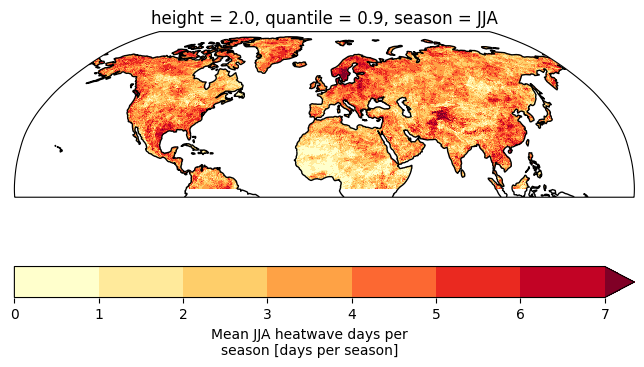

In [53]:
## masking
# --- names of coords ---
lat_name = next(n for n in summer_yearly_mean.coords if n.lower().startswith('lat'))
lon_name = next(n for n in summer_yearly_mean.coords if n.lower().startswith('lon'))

# --- 2D lon/lat matching your DataArray's grid & dim order ---
# These come back with dims ordered consistently (use them!)
lon2d, lat2d = xr.broadcast(summer_yearly_mean[lon_name], summer_yearly_mean[lat_name])

# Wrap to [-180, 180] for polygon tests
lon_wrapped = ((lon2d + 180) % 360) - 180

# --- Read Natural Earth land polygons (path -> Reader -> geometries) ---
shapefile = shpreader.natural_earth(resolution='110m', category='physical', name='land')
reader = shpreader.Reader(shapefile)
geoms = list(reader.geometries())

# --- Build mask with EXACTLY the same dims/coords as lon2d/lat2d ---
mask_np = np.zeros(lon2d.shape, dtype=bool)
# Use .values so shapely gets numpy arrays
xv = lon_wrapped.values
yv = lat2d.values
for g in geoms:
    mask_np |= sv.contains(g, xv, yv)

mask_da = xr.DataArray(
    mask_np,
    coords={lat_name: lat2d[lat_name], lon_name: lon2d[lon_name]},
    dims=lat2d.dims,  # keep the same dim order as broadcast gave us
)

# If your field has extra dims (e.g., time), broadcast mask to match
mask_da, _ = xr.broadcast(mask_da, summer_yearly_mean)

# --- Apply mask & plot ---
da_s_land = summer_yearly_mean.where(mask_da)

proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

p = da_s_land.plot.pcolormesh(ax=ax1,
                       cmap='YlOrRd',
#                       vmin=0, vmax=50,         # instead of levels=...
                       levels=np.arange(0, 8, 1),
                       transform=ccrs.PlateCarree(),
                       add_colorbar=True,
                       cbar_kwargs={'orientation': 'horizontal'},
                       rasterized=True)          # speeds up vector backends
# Add features
#ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
#                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)
ax1.coastlines('110m')                            # lighter than land polygonsha=0.30), zorder=20)

In [54]:
### saving season
## NH
summer.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/hw_mask_simclim_jja.nc')
## SH
#summer.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/SH/hw_mask_simclim_djf.nc')

In [11]:
### compute duration
# hw_mask: bool [time, lat, lon] from detect_heatwaves (already min_duration >= 3)
#ds = durations_full_event_per_season_year(hw_mask.chunk(dict(time=-1)))

# Example: JJA mean duration map for 1981 at max over years present
#jja_mean_1981 = ds["mean_duration"].sel(season="JJA", season_year=1981)

# Climatological mean over years (per season)
#jja_mean_clim = ds["mean_duration"].sel(season="JJA").mean("season_year")


In [12]:
#dur_jja_mean_clim = ds["mean_duration"].sel(season="JJA").mean("season_year")
#dur_jja_yearly_mean.to_netcdf('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_10KM-ON/Heatwaves/Russo/dur_jja_yearly_mean.nc')

In [13]:
# --- Apply mask & plot ---
'''
mean_hw_duration_land = dur_jja_mean_clim.where(mask_da)

proj = ccrs.Robinson(central_longitude=0)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})

plot = mean_hw_duration_land.plot(
    ax=ax1,
    cmap='YlOrRd',
    levels=np.arange(0, 10, 1),
    transform=ccrs.PlateCarree(),
    extend="max",
    cbar_kwargs={"orientation": "horizontal"}
)
ax1.coastlines()
'''

'\nmean_hw_duration_land = dur_jja_mean_clim.where(mask_da)\n\nproj = ccrs.Robinson(central_longitude=0)\nfig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={\'projection\': proj})\n\nplot = mean_hw_duration_land.plot(\n    ax=ax1,\n    cmap=\'YlOrRd\',\n    levels=np.arange(0, 10, 1),\n    transform=ccrs.PlateCarree(),\n    extend="max",\n    cbar_kwargs={"orientation": "horizontal"}\n)\nax1.coastlines()\n'

# Tracking heatwaves

In [5]:
def calculate_smoothed_field(
    data,
    passes,
    weights=np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]]),
    mode="wrap",
    *args,
    **kwargs
):
    """
    Calculate smoothed field based on a two-dimensional weight kernel
    and multiple smoothing passes. Default weight kernel is a 3x3
    5-point smoothing with double-weighted centre. The arguments
    "weight" and "mode" must be accepted by scipy.ndimage.convolve.
    Values at the latitude border are always set to NaN.
    Dimension names ("time_name", "lon_name", "lat_name"), size ("ntime", "nlon", "nlat")
    and resolution ("dlon", "dlat") can be passed as key=value arguments.

    Parameters
    ----------
        data : xarray.DataArray
            data to smooth
        passes : int or float
            number of smoothing passes of the 5-point smoothing
        weigths : array_like, optional
            array of weight, two-dimensional
            (see scipy.ndimage.convolve function)
        mode : string, optional
            defines how the array is extended at boundaries
            (see scipy.ndimage.convolve function)

    Returns
    -------
        smoothed data: xarray.DataArray
            Data containing the smoothed field
    """

    # perform smoothing
    smoothed = []
    for step in data[kwargs["time_name"]]:
        temp = data.sel({kwargs["time_name"]: step})
        for p in range(passes):
            temp = ndimage.convolve(temp, weights=weights, mode=mode) / np.sum(weights)

        # set latitude border values to nan
        border_size = int(weights.shape[0] / 2 + 0.5)
        temp[np.arange(-border_size, border_size), :] = np.nan

        smoothed.append(temp)

    # define DataArray
    da = xr.DataArray(
        smoothed,
        coords=[
            data[kwargs["time_name"]],
            data[kwargs["lat_name"]],
            data[kwargs["lon_name"]],
        ],
    )

    # set name
    da.name = "smooth_" + data.name

    # assign attributes
    da = da.assign_attrs(data.attrs)
    da.attrs["smooth_passes"] = passes

    return da

In [6]:
# -----------------------
# Load data 
# -----------------------
# ERA5
#einpath = '/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5'
#efvar   = 't2m'     # filename variable key
#edvar   = 't2m'     # array variable name inside file
#etemp = xr.open_mfdataset(
#    f"{einpath}/{efvar}_day_20*_0p5deg.nc",
#    chunks={"time": 365, "lon": -1, "lat": -1}
#)[edvar].squeeze()

# ICON (already regridded to 0.5° from filename)
inpath = '/capstor/scratch/cscs/edolores/old_icon/t_2m/'
fvar   = 't_2m'
dvar   = 't_2m'
temp = xr.open_mfdataset(
    f"{inpath}/remap_{fvar}_*",
    chunks={"time": 365, "lon": -1, "lat": -1}
)[dvar].squeeze()

In [7]:
###
temp

<xarray.DataArray 't_2m' (time: 4383, lat: 360, lon: 720)> Size: 5GB
dask.array<getitem, shape=(4383, 360, 720), dtype=float32, chunksize=(365, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 35kB 2006-01-01T10:30:00 ... 2017-12-31T10...
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean

In [8]:
# -----------------------
# Ensure same season selection (Apr–Oct) "we will use icon climatology"
# -----------------------
months_sel = [4,5,6,7,8,9,10]
temp  = temp.sel(time=temp["time.month"].isin(months_sel))
#etemp = etemp.sel(time=etemp["time.month"].isin(months_sel))

#### (Optional) ###########
### also slice ICON period if you like
temp = temp.sel(time=slice("2014-01-01", "2017-12-31")) ### Only 4 years

### select NH only
temp = temp.sel(lat=slice(0,90)) ### Only 4 years
###########################

# -----------------------
# Prepare time helpers
# -----------------------
t_icon   = temp.time
doy_icon = t_icon.dt.dayofyear

#t_era    = etemp.time
#doy_era  = t_era.dt.dayofyear

# Preallocate output with same shape as ICON
icon_std = xr.zeros_like(temp)

print('Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)')

# helper for circular day-of-year difference (handles wrap around)
def circ_doy_diff(a, b):
    # a, b are numpy arrays or scalars of day-of-year (1..366)
    d = np.abs(a - b)
    return np.minimum(d, 365 - d)

# -----------------------
# Main loop over ICON times; stats taken from ERA5
# -----------------------
for tt in range(t_icon.size):
    # 30-day window (±15 days) in DOY space on ERA5
    w_doy = circ_doy_diff(doy_icon.values, doy_icon.values[tt]) <= 15

    # 8-year window centered on ICON time[tt] (±1475 days) on ERA5
    w_time = np.abs((t_icon.values - t_icon.values[tt]).astype('timedelta64[D]')) <= np.timedelta64(1475, 'D')

    # Combined mask over ERA5 time
    vec = w_doy & w_time

    # Compute ERA5 climatology and std over that window
    # These broadcast over lat/lon (same 0.5° grid as ICON)
    # (If any std==0, avoid division by zero)
    clim = temp.isel(time=vec).mean('time')
    std  = temp.isel(time=vec).std('time')

    icon_std[tt, :, :] = xr.where(std > 0, (temp.isel(time=tt) - clim) / std, np.nan)

Standardizing ICON using ERA5 moving-window climatology & std (30-day DOY × ~8-year)


In [9]:
print('select months')
icon_std = icon_std.sel(time=icon_std.time.dt.month.isin([5,6,7,8,9])).compute()
icon_std

select months


<xarray.DataArray 't_2m' (time: 612, lat: 180, lon: 720)> Size: 317MB
array([[[-0.71188337, -0.6986437 , -0.2021159 , ...,  0.45034537,
          0.04895247, -0.18868645],
        [-1.0442734 , -0.4264516 ,  0.18313801, ...,  0.04129672,
         -0.31448486, -0.92791015],
        [-0.7686849 , -0.00379216,  0.47102416, ..., -0.3138487 ,
         -0.9711124 , -1.2697409 ],
        ...,
        [ 0.0342219 ,  0.03421926,  0.03421662, ...,  0.03197011,
          0.03315767,  0.03413305],
        [ 0.07412659,  0.0744155 ,  0.07471261, ...,  0.07349527,
          0.07366379,  0.07388306],
        [ 0.11062462,  0.11062191,  0.11062191, ...,  0.11062501,
          0.11062217,  0.11062208]],

       [[-1.0095396 , -1.0015047 , -1.118743  , ..., -0.14362638,
         -0.7672307 , -1.016427  ],
        [-1.2125907 , -1.3091742 , -1.302549  , ..., -0.05619486,
         -0.86783415, -1.0935079 ],
        [-1.2049688 , -1.4136286 , -1.2618423 , ..., -0.6520242 ,
         -1.1643012 , -1.1950365 ],
...
        [ 0.7541418 ,  0.7541401 ,  0.75413954, ...,  0.7458647 ,
          0.75018555,  0.75383866],
        [ 0.81664   ,  0.81787544,  0.81920105, ...,  0.8130643 ,
          0.81422275,  0.8154272 ],
        [ 0.8670752 ,  0.867075  ,  0.8670746 , ...,  0.8671029 ,
          0.86708915,  0.8670754 ]],

       [[ 0.6686919 ,  0.68149716,  0.76664025, ...,  0.7018143 ,
          0.6317548 ,  0.6831308 ],
        [ 0.47621423,  0.5221479 ,  0.5934607 , ...,  0.5696982 ,
          0.40902913,  0.37871706],
        [ 0.46134388,  0.72195184,  0.8950722 , ...,  0.351785  ,
          0.1942408 ,  0.17388044],
        ...,
        [ 1.1376344 ,  1.1376377 ,  1.1376365 , ...,  1.1315632 ,
          1.1347331 ,  1.1374105 ],
        [ 1.1424949 ,  1.1452713 ,  1.1480454 , ...,  1.1341007 ,
          1.1369016 ,  1.139706  ],
        [ 1.1517854 ,  1.1517917 ,  1.1517975 , ...,  1.1517942 ,
          1.1517868 ,  1.1517855 ]]], shape=(612, 180, 720), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2014-05-01T10:30:00 ... 2017-09-30T10:...
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 1kB 0.25 0.75 1.25 1.75 ... 88.25 88.75 89.25 89.75
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean

In [14]:
#icon_std.isel(time=300).plot()
print('write anomalies to netcdf')
icon_std.to_netcdf(inpath+'/ICON_'+fvar+'_NH_19592023_AMJJASO_daily_MA_simclim.nc')

write anomalies to netcdf


In [10]:
##### Smoothing spatially
smooth_passes=5
icon_std_smooth = calculate_smoothed_field(
        icon_std, smooth_passes, time_name='time', lat_name='lat', lon_name='lon')
# Rename the DataArray
icon_std_smooth= icon_std_smooth.rename('t_2m')
icon_std_smooth

<xarray.DataArray 't_2m' (time: 612, lat: 180, lon: 720)> Size: 635MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-0.56728959, -0.19781678,  0.17152056, ..., -0.58315635,
         -0.76567037, -0.78081098],
        ...,
        [ 0.01411533,  0.01580873,  0.02271997, ...,  0.03502665,
          0.02678488,  0.01906121],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.21559837, -1.25362997, -1.24131266, ..., -0.53671111,
         -0.90151565, -1.11459962],
...
        [ 0.73341384,  0.73411224,  0.73536785, ...,  0.72056852,
          0.72468155,  0.72993867],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.51253078,  0.64648196,  0.76595685, ...,  0.4860022 ,
          0.39180043,  0.41016537],
        ...,
        [ 1.12649075,  1.12971613,  1.13326629, ...,  1.12256541,
          1.12153282,  1.12351689],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], shape=(612, 180, 720))
Coordinates:
  * time     (time) datetime64[ns] 5kB 2014-05-01T10:30:00 ... 2017-09-30T10:...
  * lat      (lat) float64 1kB 0.25 0.75 1.25 1.75 ... 88.25 88.75 89.25 89.75
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean
    smooth_passes:  5

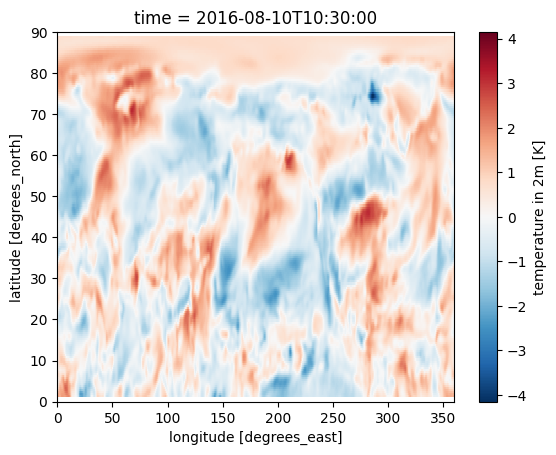

In [11]:
### we are going to use "icon_std_smooth"
#snap=icon_std.sel(time='2019-08-10',drop=True)
snap=icon_std_smooth.sel(time='2016-08-10',drop=True)
snap.plot()

/users/edolores/.env_icon/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


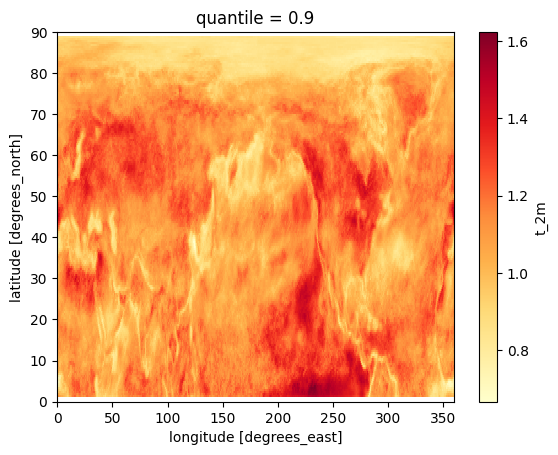

In [12]:
#q90 =icon_std.quantile(0.9, dim="time")
q90 =icon_std_smooth.quantile(0.9, dim="time")
q90.plot(cmap='YlOrRd')

ValueError: DataArray must be 2d

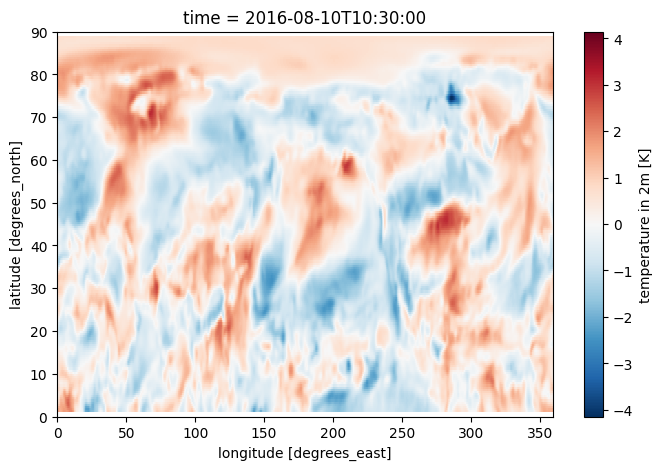

In [25]:
# Start plot of the field
fig, ax = plt.subplots(figsize=(8, 5))
snap.plot(ax=ax, cmap="RdBu_r")  # base field

# Overlay contour line(s) where values exceed q90
#(snap.isel(time=0, drop=True) > q90).plot.contour(ax=ax, colors="grey", linewidths=1.5)
(snap > q90).plot.contour(ax=ax, colors="grey", linewidths=1.5)

plt.title("2022-08-10 with regions above 90th percentile (red contours)")
plt.show()

In [13]:
##### Save binary files 1/0

In [14]:
#binary=xr.where ( icon_std> q90, 1, 0)
binary=xr.where ( icon_std_smooth> q90, 1, 0)
binary=binary.sortby('lat') ### for destinE lat descding --> ascending
binary

<xarray.DataArray 't_2m' (time: 612, lat: 180, lon: 720)> Size: 635MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(612, 180, 720))
Coordinates:
  * time      (time) datetime64[ns] 5kB 2014-05-01T10:30:00 ... 2017-09-30T10...
  * lat       (lat) float64 1kB 0.25 0.75 1.25 1.75 ... 88.25 88.75 89.25 89.75
  * lon       (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
    quantile  float64 8B 0.9

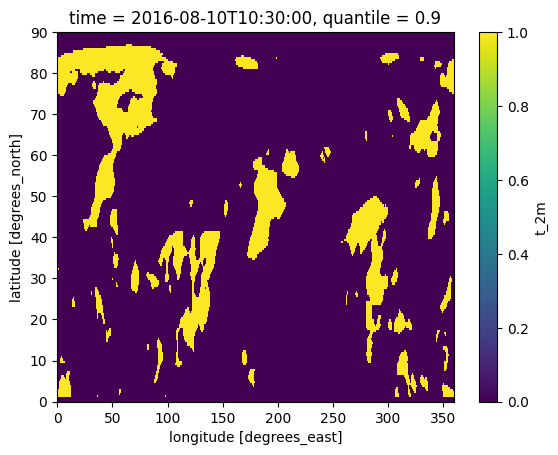

In [15]:
binary.sel(time='2016-08-10',drop=True).plot()

In [16]:
### Track heatwaves
### For pressure level temperature
#binary=binary.isel(level=0,drop=True)
outpath='/capstor/scratch/cscs/edolores/old_icon/Heatwaves/MA_TS/'

In [30]:
### intitate
anom = contrack()
anom.read_xarray(binary.to_dataset())

def _get_resolution_patched(self, dim, force=False):
    # Try to get a pandas Index (DatetimeIndex, Float64Index, etc.)
    idx = self.ds[dim].to_index()

    # Case 1: time-like coordinate → return timedelta64[h]
    if isinstance(idx, (pd.DatetimeIndex, pd.TimedeltaIndex)):
        diffs = idx[1:] - idx[:-1]  # TimedeltaIndex
        delta = np.unique(diffs.to_numpy(dtype='timedelta64[h]'))
        return delta[0]

    # Case 2: numeric coordinate (e.g., degrees) → return float
    # (Work directly with numpy array to be robust to Index subclasses)
    arr = np.asarray(idx, dtype=float)
    diffs = np.diff(arr)
    # protect against tiny numerical noise
    delta = np.unique(np.round(diffs, 10))
    return float(delta[0])


# apply the patch
contrack._get_resolution = _get_resolution_patched

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:129: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims[self._get_name_time()]


In [31]:
anom.set_up(force=True)
anom.ds=anom.ds.compute()

INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'



In [32]:
# Finally, track temperature anomalies (>=1, 50% overlap twosided, 3 timesteps persistence (here 3 days))
anom.run_contrack(variable=dvar,
                   threshold=1,
                   gorl='>=',
                   overlap=0.5,
                   persistence=3,
                   twosided=True)

### save blobs 
anom.to_netcdf(outpath+'HW_ICON_NH_20202024_AMJJASO_daily_MA_simclim.nc')

INFO: 
Run ConTrack 
########### 
    threshold:    >= 1 
    overlap:      0.5 
    persistence:  3 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

INFO: Find individual contours...
INFO: Apply overlap...
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:704: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
472 contours tracked


In [33]:
### lifecycle
anom_df = anom.run_lifecycle(flag='flag', variable=dvar)
anom_df.to_csv(outpath+'HW_ICON_NH_19592023_AMJJASO_daily_MA_simclim.csv', index=False)

INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    t_2m
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'lon'
 latitude: 'lat'

/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:848: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  weight_grid = np.ones((self.ds.dims[self._latitude_name], self.ds.dims[self._longitude_name])) * np.array((111 * self._dlat * 111 * self._dlon * weight_lat)).astype(np.float32)[:, None]
/users/edolores/.env_icon/lib/python3.12/site-packages/contrack/contrack.py:860: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.

In [34]:
###Frequency
mean_hw = xr.where(anom['flag']>1,1,0).mean(dim='time')*100
#mean_hw.plot(cmap='YlOrRd', levels=np.arange(0, 5, 0.5))

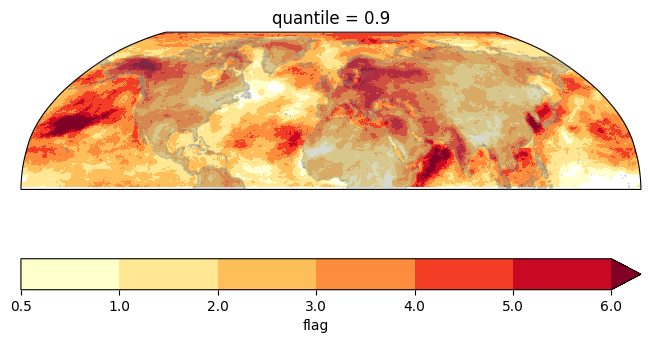

In [35]:
proj = ccrs.Robinson(central_longitude=0, globe=None)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=100, subplot_kw={'projection': proj})
plot=mean_hw.plot(ax=ax1, cmap='YlOrRd', levels=[0.5,1,2,3,4,5,6],transform=ccrs.PlateCarree(),extend="max",cbar_kwargs={"orientation":"horizontal"})
# Add features
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='grey', alpha=0.30), zorder=20)